# Bayesian NextStep

This notebook shows how to train a Bayesian recurrent neural net.



In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

!pip -q install -r ../requirements.txt

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import os
import random
import itertools

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime
from collections import defaultdict

import tensorflow_probability as tfp
tfd = tfp.distributions

# custom modules
import data
import model

print('Tensorflow version:', tf.__version__)

print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [20, 10]

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set all keras layers to use float64
tf.keras.backend.set_floatx('float32')

Tensorflow version: 2.0.0
GPU support: True


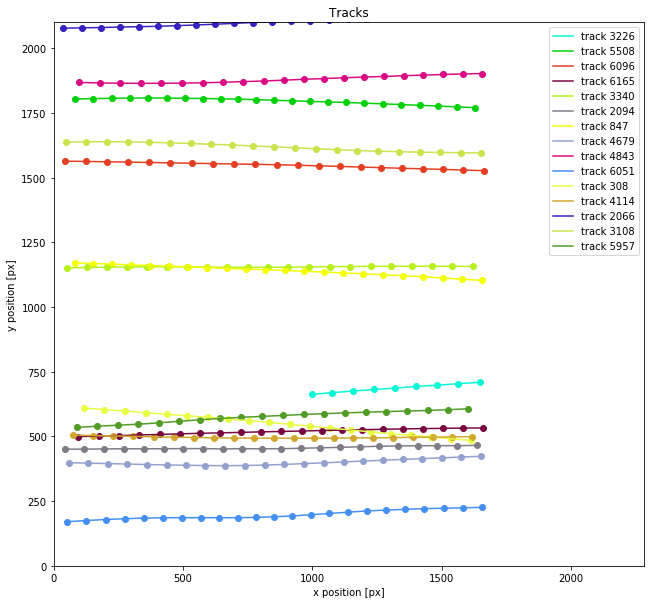

In [4]:
num_time_steps = 35
nan_value = 0
batch_size = 128


csv_data_set = data.CsvDataSet('Pfeffer/trackSortResultPfeffer/*_trackHistory_NothingDeleted.csv',
                               timesteps=num_time_steps, nan_value=nan_value)

# get tf.Dataset for sequential training
dataset_train, dataset_test = csv_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

csv_data_set.plot_random_tracks(n=15)

In [8]:
dataset_train_input = dataset_train.map(lambda a, b: a)
dataset_train_target = dataset_train.map(lambda a, b: b)

In [17]:
rnn_model = tf.keras.Sequential()

rnn_model.add(tf.keras.layers.Masking(mask_value=0., name="masking_layer",
                                      batch_input_shape=(batch_size, num_time_steps, 2)))

rnn_model.add(tf.keras.layers.LSTM(64, return_sequences=True, stateful=True, unroll=True))
rnn_model.add(tf.keras.layers.Dense(2 + 2))  # two for mean + two for variance
rnn_model.add(
    tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :2],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,2:]))
    )
)

rnn_model.summary(line_length=120)

Model: "sequential_2"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
masking_layer (Masking)                               (128, 35, 2)                                    0                 
________________________________________________________________________________________________________________________
lstm_2 (LSTM)                                         (128, 35, 64)                                   17152             
________________________________________________________________________________________________________________________
dense_2 (Dense)                                       (128, 35, 4)                                    260               
________________________________________________________________________________________________________________________
distributi

In [18]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [19]:
rnn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), 
                  loss=negloglik)

In [26]:
for epoch in range(1000):
    print("epoch {}: ".format(epoch), end='')
    for (batch_n, (inp_batch, target_batch)) in enumerate(dataset_train):
        print('.', end='')
        rnn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
        rnn_model.fit(inp_batch, target_batch, epochs=1, verbose=False)
    print('')


epoch 0: ................................................
epoch 1: ................................................
epoch 2: .....................

KeyboardInterrupt: 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



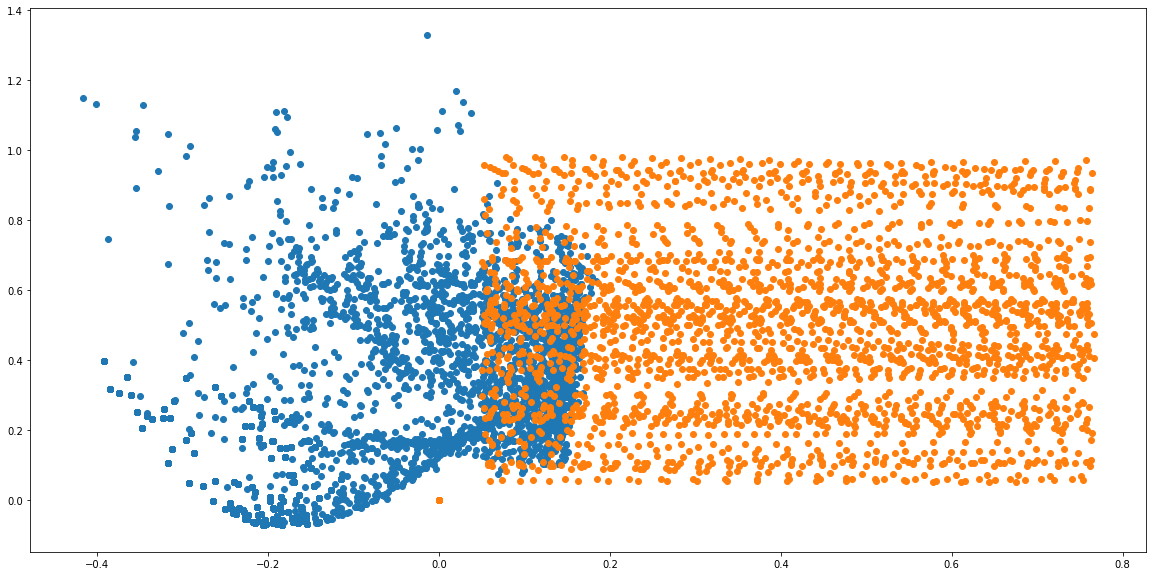

In [21]:
for (batch_n, (inp_batch, target_batch)) in enumerate(dataset_test.take(1)):
    yhat = rnn_model(inp_batch)
    
m = yhat.mean()
s = yhat.stddev()
    
plt.scatter(m[:, :, 0], m[:, :, 1])
plt.scatter(target_batch[:, :, 0], target_batch[:, :, 1])

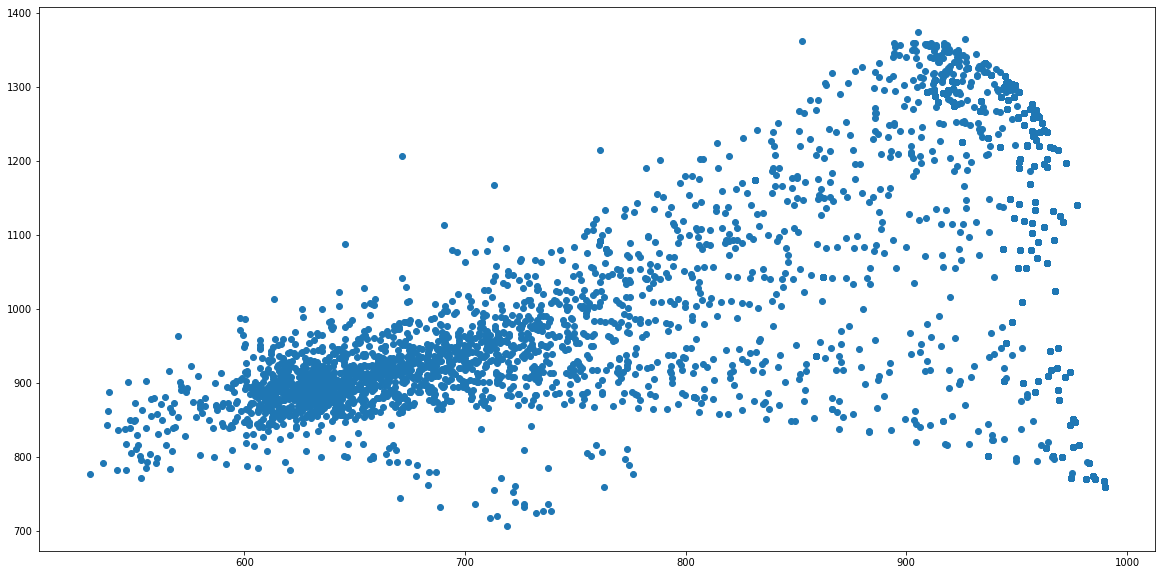

In [23]:
plt.scatter(s[:, :, 0]*2150, s[:, :, 1]*2150)

In [ ]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

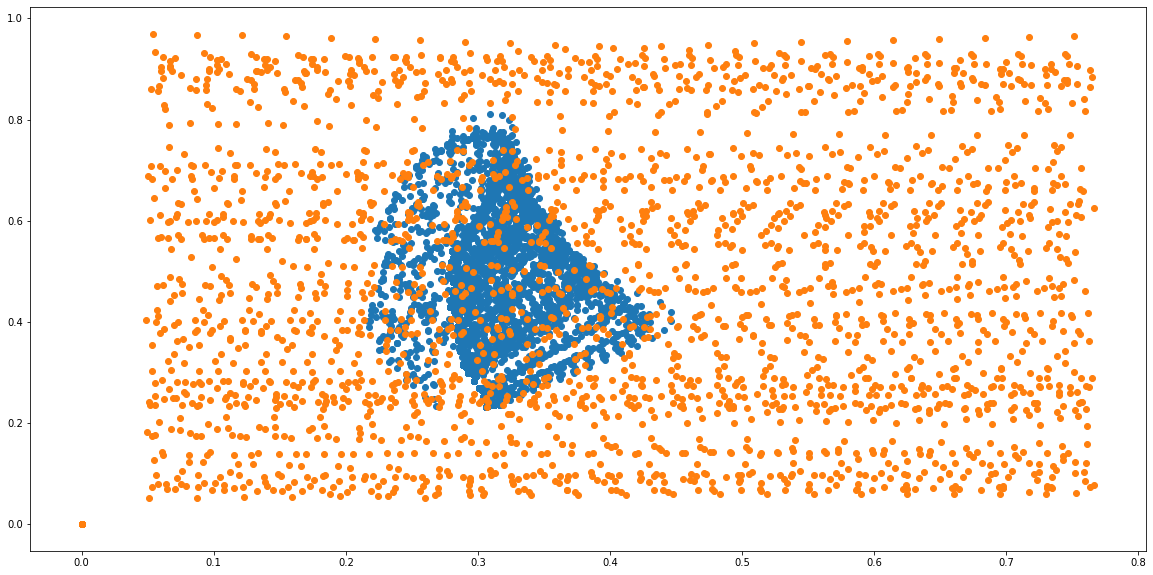

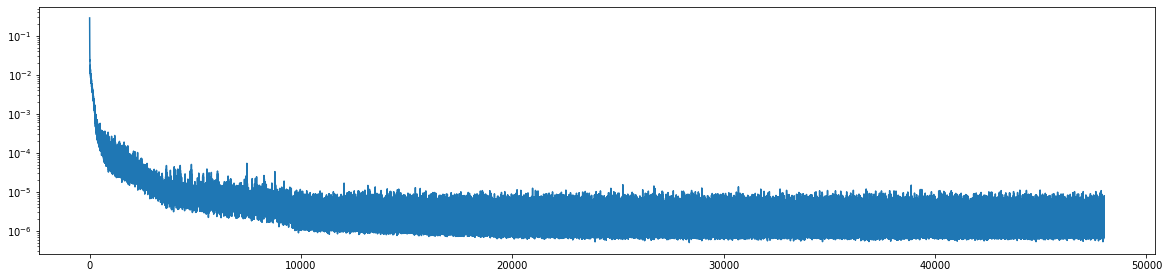

In [26]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale('log')
plt.plot(loss_history)

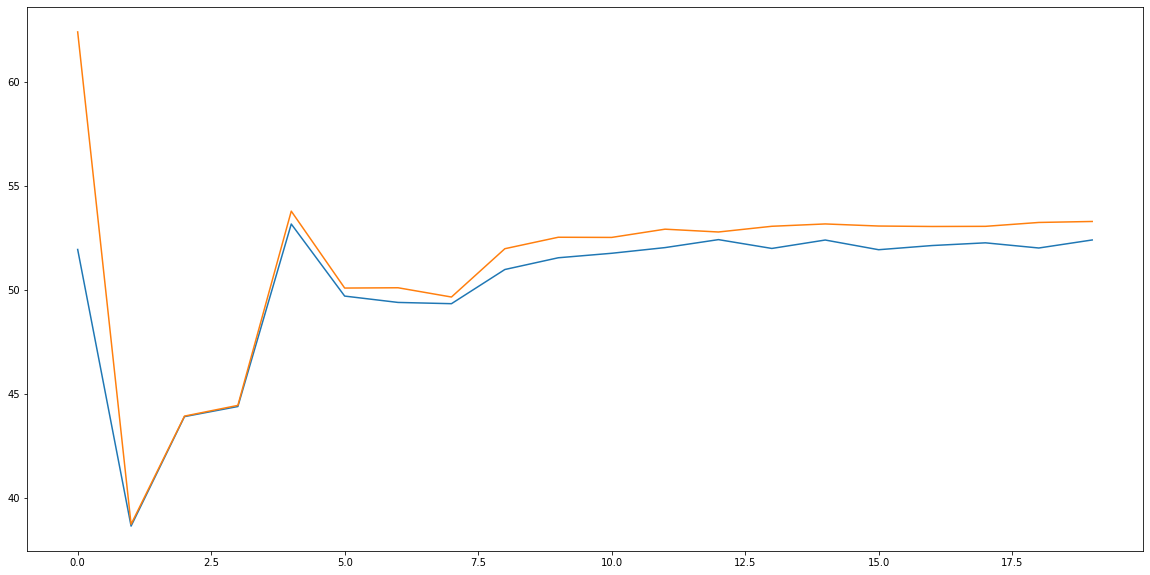

In [27]:
plt.plot(test_mae_history)
plt.plot(train_mae_history)

In [28]:
maes = np.array([])

mask_value = K.variable(np.array([nan_value, nan_value]), dtype=tf.float64)
normalization_factor = csv_data_set.belt_width

for input_batch, target_batch in dataset_test:
    # reset state
    hidden = rnn_model.reset_states()

    batch_predictions = rnn_model(input_batch)

    # Calculate the mask
    mask = K.all(K.equal(target_batch, mask_value), axis=-1)
    mask = 1 - K.cast(mask, tf.float64)
    mask = K.cast(mask, tf.float64)

    target_batch_unnormalized = target_batch * normalization_factor
    pred_batch_unnormalized = batch_predictions * normalization_factor

    batch_loss = tf.keras.losses.mean_absolute_error(target_batch_unnormalized, pred_batch_unnormalized) * mask
    
    num_time_steps_per_track = tf.reduce_sum(mask, axis=-1)
    
    batch_loss_per_track = tf.reduce_sum(batch_loss, axis=-1) / num_time_steps_per_track

    maes = np.concatenate((maes, batch_loss_per_track.numpy().reshape([-1])))
    
maes.shape

(640,)

In [29]:
np.median(maes)

1.0877150090133245

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8920ade320>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8920adea20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8920ad5f98>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8920adeeb8>],
 'fliers': [],
 'means': []}

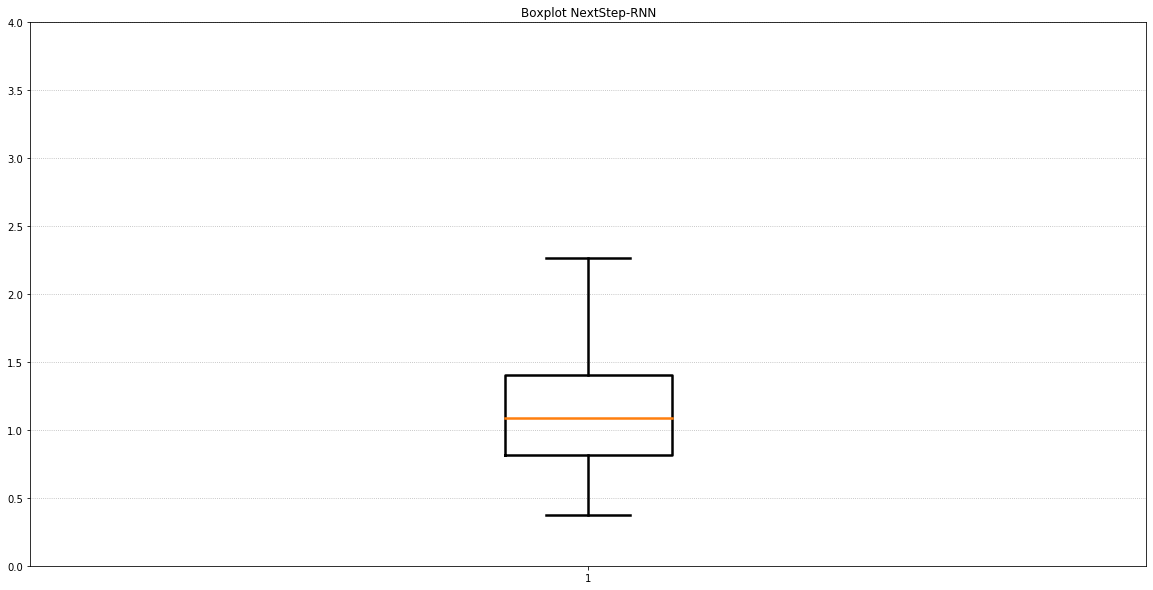

In [30]:
plt.rc('grid', linestyle=":")
fig1, ax1 = plt.subplots()
ax1.yaxis.grid(True)
ax1.set_ylim([0,4.0])
  
ax1.set_title('Boxplot NextStep-RNN')
prop = dict(linewidth=2.5)
ax1.boxplot(maes, showfliers=False, boxprops=prop, whiskerprops=prop, medianprops=prop, capprops=prop)